# Compare Sentinel-2 and Venus


 This notebook demonstrates querying the STAC API for a Venus and Sentinel-2 chip using an ROI, calculate the NDVI and plot it as a comparison

## Import and Init Environment

In [16]:
# Import

from glob import glob
import json
import os
from dotenv import load_dotenv
import pandas as pd
from pystac_client import Client
from matplotlib import pyplot as plt
import geopandas as gpd
import requests
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates 
from odc.stac import configure_rio, stac_load

Authenticate with the STAC API, if you get an error check your credentials in `.env`

In [2]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
load_dotenv()  # take environment variables from .env.

def get_new_token():
    auth_server_url = os.getenv("EDS_AUTH_URL")
    client_id = os.getenv("EDS_CLIENT_ID")
    client_secret = os.getenv("EDS_SECRET")
    token_req_payload = {'grant_type': 'client_credentials'}

    token_response = requests.post(
        auth_server_url,
        data=token_req_payload,
        verify=False,
        allow_redirects=False,
        auth=(client_id, client_secret)
    )
    token_response.raise_for_status()

    tokens = json.loads(token_response.text)
    return tokens['access_token']

token = get_new_token()

catalog = Client.open(os.getenv("EDS_API_URL"), headers={
    "Authorization": f"bearer {token}"
})

/Users/neelam.gangwani/Prod Documentation/bids2023-hackathon/bids2023/lib/python3.10/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'core-earthdaily.auth.us-east-1.amazoncognito.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
## Set the mission and the collection

In [3]:
SATELLITE = "S2" # "S2" or "VENUS"
COLLECTION = "sentinel-2-l2a"

In [4]:
## Bounding Box

In [7]:
def get_bounds_polygon_dict() -> tuple:
    #gdf = gpd.GeoDataFrame.from_features([polygon_dict])
    # gdf = gpd.read_file("./stac-notebooks/pivot_corumba.geojson")
    gdf = gpd.read_file("pivot_corumba.geojson")
    polygon = gdf.geometry.iloc[0]
    bounds = polygon.bounds
    return bounds

bbox = get_bounds_polygon_dict()
print(bbox)

(-48.5167190900641, -16.347105333917597, -48.51128016227716, -16.341886209315362)


## Define the config

In [8]:
start_date = "2019-11-01"
end_date = "2020-05-01"
max_clouds = 30 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI

In [ ]:
## Query the collection items

In [12]:
query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eda:ag_cloud_mask_available":{"eq":True}, "eo:cloud_cover":{"lt":max_clouds}},
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")


Found: 28 datasets


## Generate and load the Sentinel-2 datacube and calculate NDVI

In [13]:
# Sentinel-2 datacube
dataset = stac_load(
    items,
    bands=("red", "green", "blue","nir"),
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the resolution of the output image in metres
    # chunks={},  # Uncomment if using dask cluster
    groupby="id",
    bbox=bbox,
)

print(dataset)
dataset.attrs['sensor'] = "Sentinel-2-l2a"

# NDVI plot

meanval = dataset.mean(('x','y')) #.ed.add_indices(['NDVI'])['NDVI'].plot(ls='-',marker='o', label='Sentinel-2')
meanval.attrs['sensor'] = "Sentinel-2-l2a"

ndvixy = (meanval["nir"] - meanval["red"]) / (meanval["nir"] + meanval["red"])
meanval["ndvi"] = ndvixy

#dataset = dataset.load()
meanval = meanval.load()

print(meanval)


<xarray.Dataset> Size: 3MB
Dimensions:      (y: 122, x: 122, time: 28)
Coordinates:
  * y            (y) float64 976B -1.844e+06 -1.844e+06 ... -1.845e+06
  * x            (x) float64 976B -5.401e+06 -5.401e+06 ... -5.4e+06 -5.4e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 224B 2020-04-27T13:36:54.039000 ... 20...
Data variables:
    red          (time, y, x) uint16 834kB 132 132 139 139 ... 1926 1970 1970
    green        (time, y, x) uint16 834kB 313 313 301 301 ... 1632 1576 1576
    blue         (time, y, x) uint16 834kB 111 111 125 125 ... 1406 1316 1316
    nir          (time, y, x) uint16 834kB 3120 3120 3132 ... 2988 2934 2934
<xarray.Dataset> Size: 1kB
Dimensions:      (time: 28)
Coordinates:
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 224B 2020-04-27T13:36:54.039000 ... 20...
Data variables:
    red          (time) float64 224B 1.718e+03 1.75e+03 ... 1.796e+03 1.797e+03
    green        (time) float64 224B 1.288e+03 1.299

## Generate and load the Venus datacube

In [14]:
COLLECTION = "venus-l2a"
#    BANDS = ("red", "green", "blue", ) # "nir08", "rededge", "yellow", "coastal"

query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}},
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

datasetv = stac_load(
    items,
    bands=("red", "green", "blue","nir08", "detailed_cloud_mask"),
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the resolution of the output image in metres
    # chunks={},  # Uncomment if using dask cluster
    # geobox=dataset.odc.geobox,
    groupby="id",
    bbox=bbox,
)

print(datasetv)
datasetv.attrs['sensor'] = "Venus-l2a"

# NDVI plot
meanvalV = datasetv.mean(('x','y')) #.ed.add_indices(['NDVI'])['NDVI'].plot(ls='-',marker='o', label='Sentinel-2')
meanvalV.attrs['sensor'] = "Venus-l2a"

ndvixyV = (meanvalV["nir08"] - meanvalV["red"]) / (meanvalV["nir08"] + meanvalV["red"])
meanvalV["ndvi"] = ndvixyV

#dataset = dataset.load()
meanvalV = meanvalV.load()
print (meanvalV)


/Users/neelam.gangwani/Prod Documentation/bids2023-hackathon/bids2023/lib/python3.10/site-packages/pystac_client/item_search.py:836: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found: 15 datasets
<xarray.Dataset> Size: 3MB
Dimensions:              (y: 122, x: 122, time: 15)
Coordinates:
  * y                    (y) float64 976B -1.844e+06 -1.844e+06 ... -1.845e+06
  * x                    (x) float64 976B -5.401e+06 -5.401e+06 ... -5.4e+06
    spatial_ref          int32 4B 3857
  * time                 (time) datetime64[ns] 120B 2020-05-01T13:41:18 ... 2...
Data variables:
    red                  (time, y, x) uint16 447kB 1200 1210 1210 ... 2620 2650
    green                (time, y, x) uint16 447kB 1350 1360 1360 ... 2240 2230
    blue                 (time, y, x) uint16 447kB 1160 1160 1170 ... 1990 1970
    nir08                (time, y, x) uint16 447kB 4220 4310 4300 ... 3520 3530
    detailed_cloud_mask  (time, y, x) float32 893kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
<xarray.Dataset> Size: 784B
Dimensions:              (time: 15)
Coordinates:
    spatial_ref          int32 4B 3857
  * time                 (time) datetime64[ns] 120B 2020-05-01T13:41:18 ... 2...


# Results (plots)

## Plot and Compare the NDVI

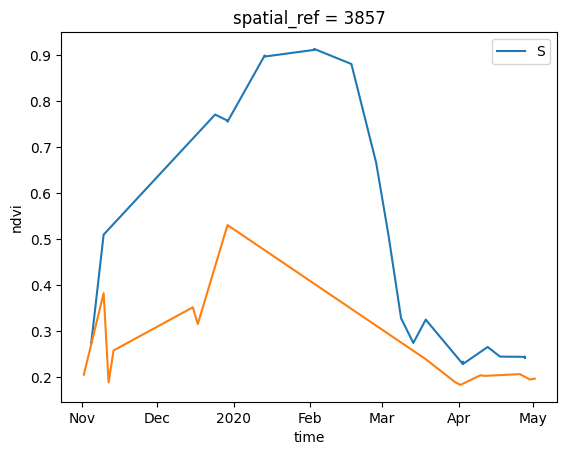

In [15]:

plt.title('NDVI between Sentinel-2 and Venus')

#for sensor in [meanval, meanvalV]:
meanval["ndvi"].plot()
plt.legend("STentinel 2")
#plt.suptitle("Sentinel 2")

meanvalV["ndvi"].plot()
#plt.legend("Venus")
#plt.suptitle("Venus")
    
plt.show()